In [1]:
'''
Import libraries
'''
import pandas as pd
from utils import *
import warnings
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import importlib
import statsmodels
from arch import arch_model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from tqdm import tqdm


warnings.filterwarnings("ignore")
%load_ext autoreload
%autoreload 2


C:\Users\Amirmahdi\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
'''
Read the data and split it into training and testing sets
'''
all_data = pd.read_csv('Data/raw_data.csv', index_col = 0)
all_data.index = pd.to_datetime(all_data.index)

test_data = all_data.iloc[-int(len(all_data) * 0.1):]
train_data = all_data.iloc[:-int(len(all_data) * 0.1)]

1 - GARCH

In [3]:
'''
In GARCH models we only need the returns
'''
garch_data_train = train_data[['Return', 'Realized Volatility']]
garch_data_test = test_data[['Return', 'Realized Volatility']]

Tests Before Running GARCH model

Test 1: Stationarity Test on returns

In [4]:
'''
Augmented Dickey-Fuller test on returns. If the p-value is less than a chosen significance level (commonly 0.05), you reject the null hypothesis of a unit root, indicating that the time series is stationary.

we observe that the returns are stationary.
'''

stationarity_test(garch_data_train['Return'])

ADF Statistic: -12.838059
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


Test 2: Autocorrelation Test on Returns

In [5]:
'''
Ljung-Box test. If the p-value is less than a chosen significance level (commonly 0.05), you reject the null hypothesis that there is no autocorrelation. This suggests that there is significant autocorrelation in the series.

We observe that we have high autocorrelation in returns.
'''
Ljung_Box_Test(garch_data_train['Return'], 15)

,lb_stat,lb_pvalue
1,43.685588,3.856010e-11
2,67.318715,2.409499e-15
3,67.809761,1.256470e-14
4,75.030998,1.962733e-15
5,80.673246,6.067195e-16
6,111.644789,9.221163e-22
7,164.576624,3.488526e-32
8,196.325899,3.796672e-38
9,236.714128,6.333430e-46
10,246.903415,2.429779e-47


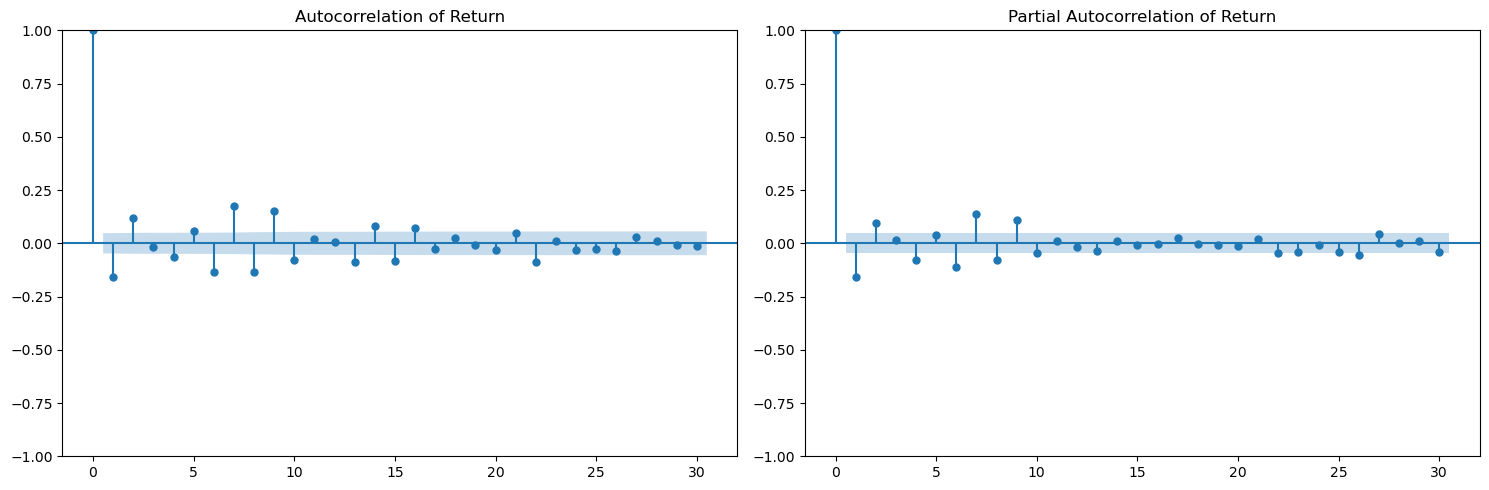

In [6]:
'''
We also plot the autocorrelation and partial autocorrelation functions to visualize the autocorrelation in the series.
'''
plot_autocorrelations(['Return'], [garch_data_train['Return']])


Since we have autocorrlation in the returns, we need to model the returns using an ARIMA model to remove the autocorrelation.

In [7]:
'''
We find the best ARIMA model for the returns using the AIC and BIC criteria.

We find out that the best model is ARIMA(0, 0, 2) which is an MA(2) model.
'''

returns = garch_data_train[['Return']]

# Define the range of values for p, d and q
p_values = range(0, 3)
d_values = range(0, 1)
q_values = range(0, 3)

# Initialize variables to store the best results
best_aic = np.inf
best_bic = np.inf
best_order_aic = None
best_order_bic = None

# Iterate over all combinations of p, d and q
for p in p_values:
    for d in d_values:
        for q in q_values:
            # Fit the ARIMA model
            model = ARIMA(returns, order=(p, d, q))
            result = model.fit()

            # Update the best AIC model
            if result.aic < best_aic:
                best_aic = result.aic
                best_order_aic = (p, d, q)

            # Update the best BIC model
            if result.bic < best_bic:
                best_bic = result.bic
                best_order_bic = (p, d, q)
# Print the best models
print(f"Best AIC model: ARIMA{best_order_aic} with AIC={best_aic}")
print(f"Best BIC model: ARIMA{best_order_bic} with BIC={best_bic}")

Best AIC model: ARIMA(0, 0, 2) with AIC=-10118.357379436335
Best BIC model: ARIMA(0, 0, 2) with BIC=-10096.620349907802


In [8]:
'''
We find the residuals from the ARIMA model and add them to the data for both the training and testing sets.
'''

returns = all_data['Return']

# Fit an ARIMA model
arima_model = ARIMA(returns, order=(0, 0, 2))
arima_result = arima_model.fit()

# Get the residuals from the ARIMA model
all_data['ARIMA_res'] = arima_result.resid

garch_data_train['ARIMA_res'] = all_data['ARIMA_res'].loc[garch_data_train.index]
garch_data_test['ARIMA_res'] = all_data['ARIMA_res'].loc[garch_data_test.index]

Now we test the residuals of the ARIMA model for autocorrelation: We still have autocorrelation which is one of the reasons that GARH might not work.


In [9]:
'''
Test for autocorrelation in the residuals. We observe that the first lags are now without autocorrelation but the longer lags still have autocorrelation.
'''
Ljung_Box_Test(garch_data_train['ARIMA_res'], 15)

,lb_stat,lb_pvalue
1,0.110226,7.398871e-01
2,0.409049,8.150348e-01
3,1.485209,6.856882e-01
4,6.959842,1.380257e-01
5,7.891001,1.623460e-01
6,23.963662,5.303568e-04
7,55.107541,1.419519e-09
8,67.070651,1.877348e-11
9,91.509991,8.100256e-16
10,95.703272,3.933007e-16


Test of autocorrelation of squared residuals. In GARCH model we assume that the squared residuals are correlated.

In [10]:
'''
We do the Ljung-Box test and observe that the squared residuals are correlated.
'''
Ljung_Box_Test(garch_data_train['ARIMA_res'] ** 2, 15)

,lb_stat,lb_pvalue
1,259.658737,2.036589e-58
2,626.776227,7.893536e-137
3,790.309095,5.469499e-171
4,897.016797,7.379300e-193
5,1030.244384,1.701249e-220
6,1239.850925,1.134599e-264
7,1345.889879,1.966585e-286
8,1571.217237,0.000000e+00
9,1664.323753,0.000000e+00
10,1768.042506,0.000000e+00


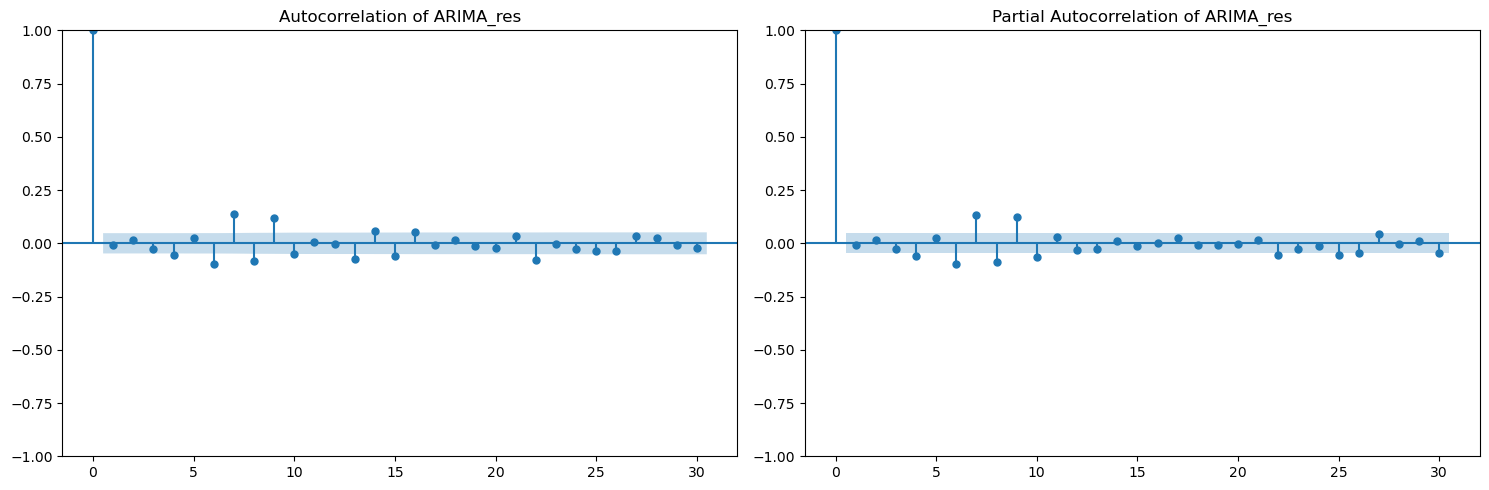

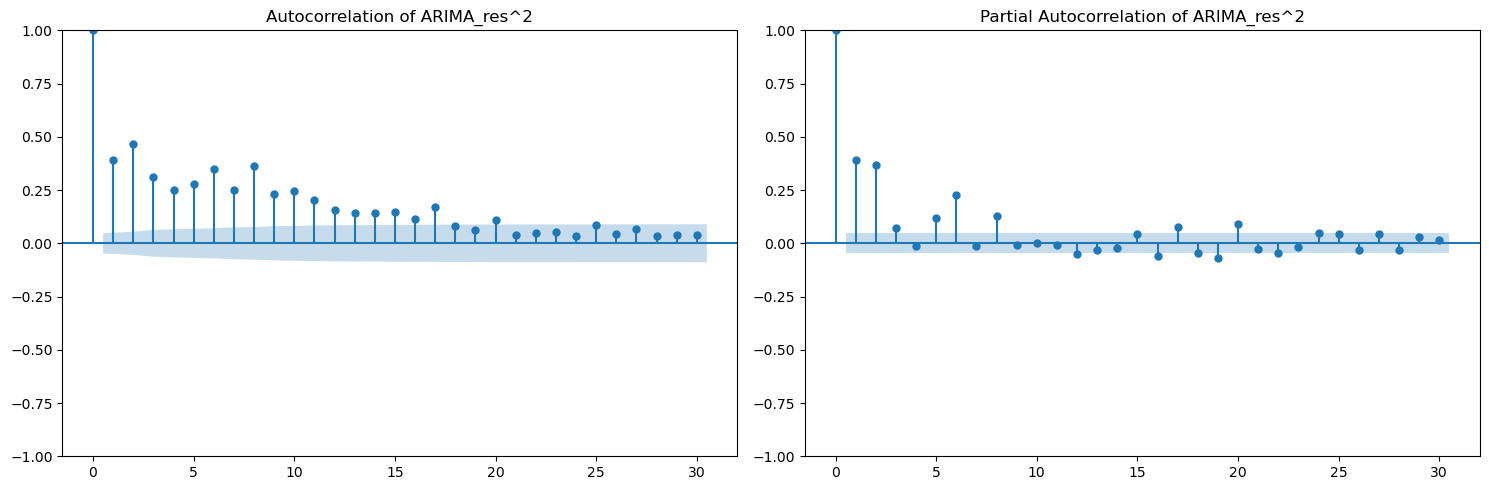

In [13]:
'''
We also plot the autocorrelation and partial autocorrelation functions to visualize the autocorrelation in the residuals and squared residuals.
'''
plot_autocorrelations(['ARIMA_res'], [garch_data_train['ARIMA_res']])
plot_autocorrelations(['ARIMA_res^2'], [garch_data_train['ARIMA_res'] ** 2])


Now we will fit a GARCH model to the residuals of the ARIMA model

In [72]:
'''
Class for GARCH model
'''
class GARCHModel:
    def __init__(self, p, q, dist='normal', start_vals=None):   # p and q are the orders of the GARCH model
        self.p = p
        self.q = q
        self.dist = dist
        self.model = None
        self.result = None
        self.resid = None
        self.conditional_volatility = None
        self.start_vals = start_vals

    def fit_garch_model(self, data, disp='final'):  # fitting the GARCH model
        self.model = arch_model(data, vol='GARCH', p=self.p, q=self.q, dist=self.dist, mean='Zero')
        self.result = self.model.fit(disp=disp, options={'maxiter': 100000})
        self.resid = self.result.resid
        self.conditional_volatility = self.result.conditional_volatility

    def plot_results(self): # plotting the results of the GARCH model
        print(self.result.summary())
        self.result.plot()
        plt.show()

    def EngleArchTest_(self):   # testing for ARCH effect
        test_result = statsmodels.stats.diagnostic.het_arch(self.resid, nlags=10, store=False, ddof=0)
        print(f"Test results: {test_result}")

    def forecast(self, horizon=1):  # forecasting the volatility
        forecast = self.result.forecast(horizon=horizon)
        return forecast




In [73]:
'''
We will find the best hyperparameters which are the orders of the GARCH model and the distribution of the residuals based on the AIC and BIC criteria.

We find out that for all distributions, the best model is GARCH(1,1).
'''
p_values = range(1, 7)
q_values = range(1, 7)

# Define the distributions
distributions = ['normal', 't', 'skewt']

# Initialize variables to store the best results
best_bic = np.inf
best_aic = np.inf
best_model_bic = None
best_model_aic = None

# Iterate over all combinations of p, q, and distribution
for dist in distributions:
    for p in p_values:
        for q in q_values:
            # Fit the GARCH model
            garch_model = GARCHModel(p,q, dist = dist)
            garch_model.fit_garch_model(garch_data_train['ARIMA_res'] * 100, disp = 'off')
            # Get BIC, AIC
            bic = garch_model.result.bic
            aic = garch_model.result.aic

            # Update the best BIC model
            if bic < best_bic:
                best_bic = bic
                best_model_bic = [p,q]

            # Update the best AIC model
            if aic < best_aic:
                best_aic = aic
                best_model_aic = [p,q]

    # Print the best models
    print(f"Best model for {dist} distribution based on BIC score:", best_model_bic)
    print(f"Best model for {dist} distribution based on AIC score:", best_model_aic)

Best model for normal distribution based on BIC score: [1, 1]
Best model for normal distribution based on AIC score: [1, 1]
Best model for t distribution based on BIC score: [1, 1]
Best model for t distribution based on AIC score: [1, 1]
Best model for skewt distribution based on BIC score: [1, 1]
Best model for skewt distribution based on AIC score: [1, 1]


In [74]:
'''
Now based on our findings in the previous parts, we will fit a GARCH(1,1) model with different distributions to see which distribution fits the best.

We find out that the best distribution is the skewed t distribution.
'''

distributions = ['normal', 't', 'skewt']

# Initialize variables to store the best results
best_bic = np.inf
best_aic = np.inf
best_dist_bic = None
best_dist_aic = None

# Iterate over all distributions
for dist in distributions:
    # Fit the GARCH model
    garch_model = GARCHModel(1,1, dist = dist)
    garch_model.fit_garch_model(garch_data_train['ARIMA_res'] * 100, disp = 'off')
    # Get BIC, AIC
    bic = garch_model.result.bic
    aic = garch_model.result.aic

    # Update the best BIC distribution
    if bic < best_bic:
        best_bic = bic
        best_dist_bic = dist

    # Update the best AIC distribution
    if aic < best_aic:
        best_aic = aic
        best_dist_aic = dist


# Print the best distributions
print(f"Best BIC distribution: {best_dist_bic}")
print(f"Best AIC distribution: {best_dist_aic}")

Best BIC distribution: skewt
Best AIC distribution: skewt


Iteration:      1,   Func. Count:      7,   Neg. LLF: 18738.739230204403
Iteration:      2,   Func. Count:     14,   Neg. LLF: 5627.538803640051
Iteration:      3,   Func. Count:     22,   Neg. LLF: 2209.7095367990455
Iteration:      4,   Func. Count:     29,   Neg. LLF: 37148.65320134751
Iteration:      5,   Func. Count:     37,   Neg. LLF: 2189.9351689304895
Iteration:      6,   Func. Count:     43,   Neg. LLF: 2189.999472358282
Iteration:      7,   Func. Count:     50,   Neg. LLF: 2190.3550165003953
Iteration:      8,   Func. Count:     57,   Neg. LLF: 2189.7487023533113
Iteration:      9,   Func. Count:     63,   Neg. LLF: 2189.748163281113
Iteration:     10,   Func. Count:     69,   Neg. LLF: 2189.7481624442867
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2189.7481624442867
            Iterations: 10
            Function evaluations: 69
            Gradient evaluations: 10
                             Zero Mean - GARCH Model Results    

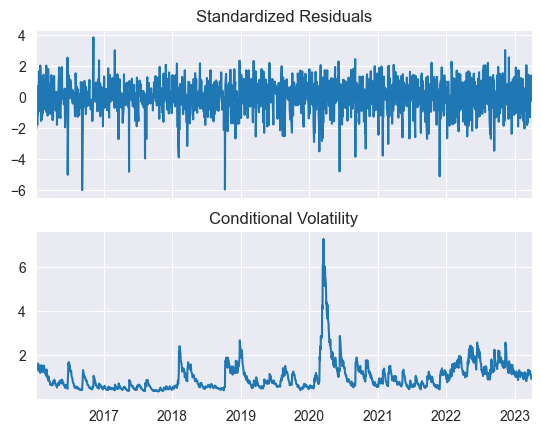

In [75]:
'''
Now we fit the GARCH(1,1) model with the skewed t distribution to the residuals of the ARIMA model and see the results.
'''
garch_1_1_t = GARCHModel(1,1, dist = 'skewt')
garch_1_1_t.fit_garch_model(garch_data_train['ARIMA_res'] * 100)
garch_1_1_t.plot_results()

Tesing for autocorrelation of standardized residuals. Since Residuals are i.i.d there should be no autocorrelation in the residuals


In [76]:
'''
We do the Ljung-Box test and observe that the standardized residuals have autocorrelation. This means that the model is not capturing all the information in the data.
'''

std_resid = garch_1_1_t.resid / garch_1_1_t.conditional_volatility
Ljung_Box_Test(std_resid, 15)

,lb_stat,lb_pvalue
1,13.045226,0.000304
2,15.595923,0.000411
3,17.141381,0.000661
4,18.389364,0.001036
5,19.506883,0.001546
6,20.847737,0.001954
7,23.170901,0.001592
8,23.545318,0.002730
9,23.550660,0.005071
10,25.124991,0.005114


Arch effect test: The squared residuals should be correlated

In [77]:
'''
We do the Engle's ARCH test and observe that the squared residuals are correlated.
'''
garch_1_1_t.EngleArchTest_()

Test results: (557.7166984303094, 1.999553193639207e-113, 82.86822691447588, 1.7697878811865205e-138)


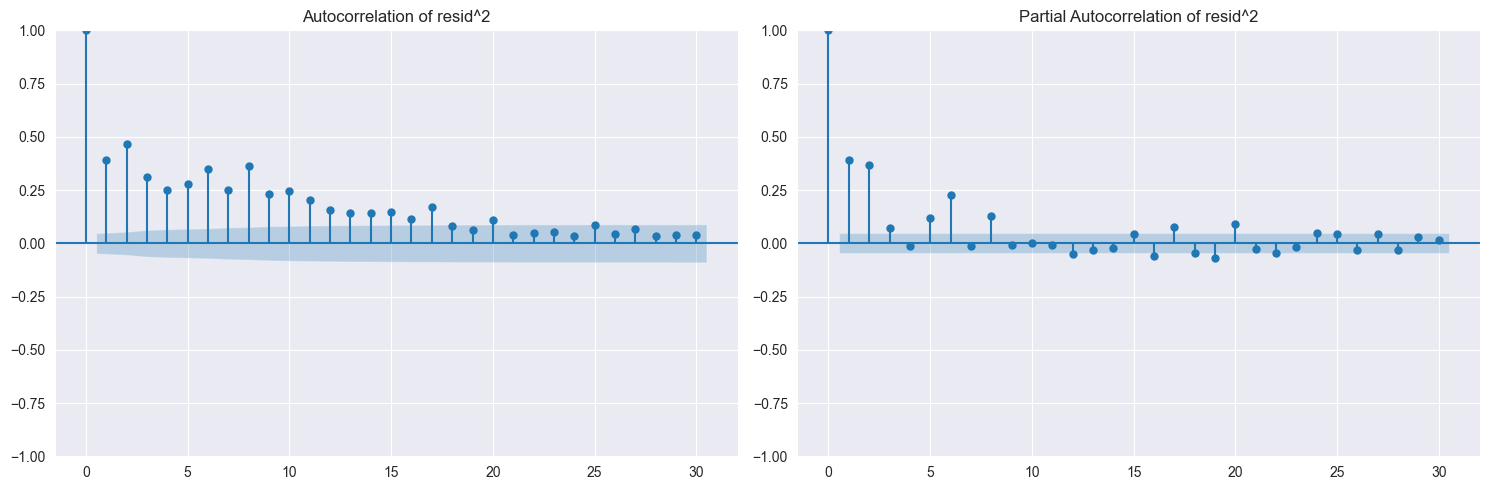

In [78]:
'''
We also see this autocorrelation in the plots
'''
plot_autocorrelations(['resid^2'], [garch_1_1_t.resid ** 2])

In [79]:
'''
parameters of the model
'''
garch_1_1_t.result.params

omega       0.017972
alpha[1]    0.184558
beta[1]     0.815442
eta         6.351610
lambda     -0.141489
Name: params, dtype: float64

Check the skewt distribution of the standardized residuals

Shape: -1.7918323804017717, Location: 0.9590790882549758, Scale: 1.4018662203084402


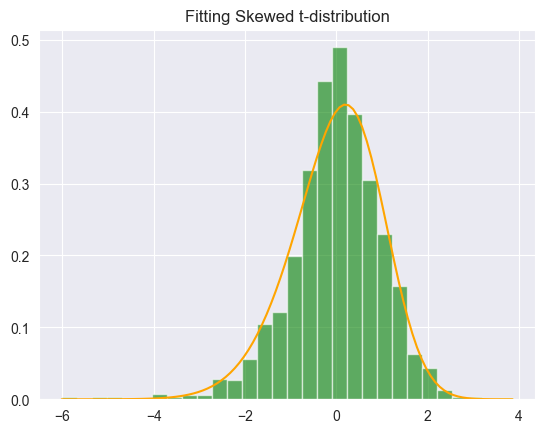

In [80]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skewnorm

data = std_resid 

# Fit a skewed t-distribution to the data
a, loc, scale = skewnorm.fit(data)
print(f"Shape: {a}, Location: {loc}, Scale: {scale}")

x = np.linspace(min(data), max(data), 100)
pdf = skewnorm.pdf(x, a, loc, scale)

# Plot the histogram of the data and the fitted distribution
plt.hist(data, bins=30, density=True, alpha=0.6, color='g')
plt.plot(x, pdf, 'orange')
plt.title('Fitting Skewed t-distribution')
plt.show()

Volatility forecasting with GARCH

In [81]:
def forecast_volatility_with_GARCH(train, validation, dates, window_size, horizon, model):
    '''
    
    :param train: the training set
    :param validation: the validtion set
    :param dates: list of all dates
    :param window_size: the window that we train our data on
    :param horizon: the number of days we want to forecast
    :param model: the GARCH model
    :return: 
    '''
    # Create lists to store the predictions, actual values and prediction dates
    predictions = []
    prediction_dates = []
    params = []

    # Perform rolling window validation
    for i in tqdm(range(window_size, len(train) + len(validation), horizon)):
        if i < len(train):
            train_temp = train[:i]
        else:
            train_temp = returns[i - window_size:i]
        model.fit_garch_model(train_temp, disp='off')
        pred = model.forecast(horizon=horizon)
        predictions.extend(pred.variance.values[-1, :] ** 0.5)
        # Add the corresponding dates to the prediction_dates list
        prediction_dates.extend(dates[i:i+horizon])
        params.append(model.result.params)

    predictions = predictions[:len(validation)]
    prediction_dates = prediction_dates[:len(validation)]

    return predictions, prediction_dates, params


In [82]:
'''
Now we will find the pest p, q which are able to best predict the volatility on the validation set.
'''

residuals = (garch_data_train['ARIMA_res']).values

# Get the dates from the DataFrame
dates = garch_data_train.index.values

# Split the data into training, validation and testing sets
train_size = int(len(residuals) * 8 / 9)
train, validation= residuals[:train_size], residuals[train_size:],

real_volatility_validation = garch_data_train['Realized Volatility'].values[train_size:]

# Define the initial window size and the forecast horizon
window_size = len(train)  # Adjust as needed
horizon = 1  # Adjust as needed

p_values = range(1, 3)
q_values = range(1, 3)

best_r_square = -np.inf
best_param_r_square = None
best_mse = np.inf
best_param_mse = None
best_mae = np.inf
best_param_mae = None
best_mape = np.inf
best_param_mape = None


distributions = ['skewt']
for dist in distributions:
    for p in p_values:
        for q in q_values:
            # Fit the GARCH model
            garch_model = GARCHModel(p,q, dist = dist)
            predictions, prediction_dates, params = forecast_volatility_with_GARCH(train, validation, dates, window_size, horizon, garch_model)
            predictions = [x for x in predictions]
            # RMSE error
            rmse =  mean_squared_error(real_volatility_validation, predictions) ** 0.5
            mae = np.mean(np.abs(real_volatility_validation - predictions))
            r_square = r2_score(real_volatility_validation, predictions)
            MAPE =  mean_absolute_percentage_error(real_volatility_validation, predictions)
            print(f"MSE for GARCH({p},{q}) with {dist} distribution: {rmse}")
            print(f"MAE for GARCH({p},{q}) with {dist} distribution: {mae}")
            print(f"R^2 for GARCH({p},{q}) with {dist} distribution: {r_square}")
            print(f"MAPE for GARCH({p},{q}) with {dist} distribution: {MAPE}")
            if rmse < best_mse:
                best_mse = rmse
                best_param_mse = (p, q, dist)
            if mae < best_mae:
                best_mae = mae
                best_param_mae = (p, q, dist)
            if r_square > best_r_square:
                best_r_square = r_square
                best_param_r_square = (p, q, dist)
            if MAPE < best_mape:
                best_mape = MAPE
                best_param_mape = (p, q, dist)

print(f"Best MSE model: GARCH{best_param_mse} with RMSE={best_mse}")
print(f"Best MAE model: GARCH{best_param_mae} with MAE={best_mae}")
print(f"Best R^2 model: GARCH{best_param_r_square} with R^2={best_r_square}")
print(f"Best MAPE model: GARCH{best_param_mape} with MAPE={best_mape}")



100%|██████████| 189/189 [00:03<00:00, 59.12it/s]


MSE for GARCH(1,1) with skewt distribution: 0.005214268648524278
MAE for GARCH(1,1) with skewt distribution: 0.003998678907219775
R^2 for GARCH(1,1) with skewt distribution: -0.20301906179158147
MAPE for GARCH(1,1) with skewt distribution: 0.3830160718180506


 74%|███████▍  | 140/189 [00:08<00:02, 17.24it/s]C:\Users\Amirmahdi\PycharmProjects\OptimizationMethods\PS1\venv\Lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
100%|██████████| 189/189 [00:17<00:00, 10.80it/s]


MSE for GARCH(1,2) with skewt distribution: 0.005012142451072128
MAE for GARCH(1,2) with skewt distribution: 0.003922078011858062
R^2 for GARCH(1,2) with skewt distribution: -0.1115589862438946
MAPE for GARCH(1,2) with skewt distribution: 0.3825294571959024


100%|██████████| 189/189 [00:20<00:00,  9.42it/s]


MSE for GARCH(2,1) with skewt distribution: 0.005123007469305666
MAE for GARCH(2,1) with skewt distribution: 0.003988991786119227
R^2 for GARCH(2,1) with skewt distribution: -0.16127661563393314
MAPE for GARCH(2,1) with skewt distribution: 0.3835718780961938


  4%|▎         | 7/189 [00:00<00:18, 10.11it/s]C:\Users\Amirmahdi\PycharmProjects\OptimizationMethods\PS1\venv\Lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
 35%|███▌      | 67/189 [00:06<00:11, 10.73it/s]C:\Users\Amirmahdi\PycharmProjects\OptimizationMethods\PS1\venv\Lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
 75%|███████▍  | 141/189 [00:16<00:06,  7.72it/s]C:\Users\Amirmahdi\PycharmProjects\OptimizationMethods\PS1\venv\Lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.



MSE for GARCH(2,2) with skewt distribution: 0.0049889776222475255
MAE for GARCH(2,2) with skewt distribution: 0.003934095349948215
R^2 for GARCH(2,2) with skewt distribution: -0.10130805219357009
MAPE for GARCH(2,2) with skewt distribution: 0.3862672883480757
Best MSE model: GARCH(2, 2, 'skewt') with RMSE=0.0049889776222475255
Best MAE model: GARCH(1, 2, 'skewt') with MAE=0.003922078011858062
Best R^2 model: GARCH(2, 2, 'skewt') with R^2=-0.10130805219357009
Best MAPE model: GARCH(1, 2, 'skewt') with MAPE=0.3825294571959024


We choose the best model from the previous part based on the MAPE and forecast the volatility on the testing set.

In [83]:
garch_model = GARCHModel(1,2, dist = 'skewt')
test_train = residuals[-train_size:]
indexes = all_data.iloc[-(train_size + len(test_data)):].index.values
predictions, prediction_dates, params = forecast_volatility_with_GARCH(residuals, garch_data_test['ARIMA_res'].values, all_data.index.values, len(residuals), horizon, garch_model)

real_volatility_test = test_data['Realized Volatility'].values
rmse = mean_squared_error(real_volatility_test, predictions) ** 0.5
mae = np.mean(np.abs(real_volatility_test - predictions))
r_2 = r2_score(real_volatility_test, predictions)
mape = mean_absolute_percentage_error(real_volatility_test, predictions)
print(f"RMSE for GARCH: {rmse}")
print(f"MAE for GARCH: {mae}")
print(f"R^2 for GARCH: {r_2}")
print(f"MAPE for GARCH: {mape}")


 79%|███████▊  | 148/188 [00:25<00:07,  5.69it/s]C:\Users\Amirmahdi\PycharmProjects\OptimizationMethods\PS1\venv\Lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
100%|██████████| 188/188 [00:31<00:00,  5.97it/s]

RMSE for GARCH: 0.002720223454381391
MAE for GARCH: 0.0021940945411759714
R^2 for GARCH: -0.5414798754770869
MAPE for GARCH: 0.4324785959429586


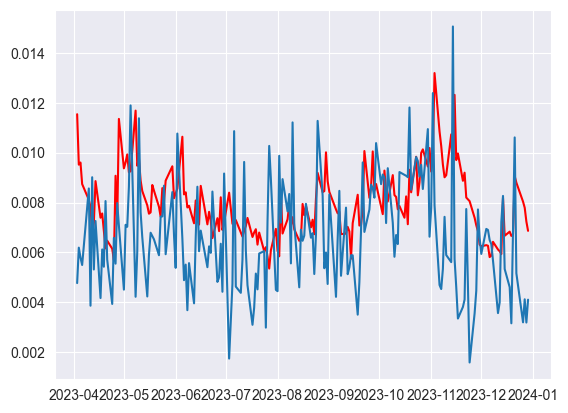

In [84]:
'''
plot the real and predicted volatility
'''
plt.plot(test_data.index, predictions, label='Predicted Volatility', color = 'r')
plt.plot(test_data.index, real_volatility_test, label='Real Volatility')

In [85]:
data_results = pd.DataFrame({'Date': test_data.index, 'Realized Volatility': real_volatility_test, 'Predicted Volatility': predictions})
data_results.to_csv('Outputs/Models/GARCH/GARCH_results.csv')

################################################################

VAR models

In [14]:
from statsmodels.tsa.api import VAR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from statsmodels.tsa.stattools import grangercausalitytests
from tqdm import tqdm

In [15]:
'''
Read the data and split it into training and validation sets
'''
data = pd.read_csv('data/raw_data_stationary_abs_return.csv', index_col = 0, parse_dates = True)

train_data = data.iloc[:-int(len(data) * 1/10)]
valid_data = data.iloc[-int(len(data) * 1/10):]


Stationary test: Features in VAR should be stationary

In [16]:
'''
We see that all the columns are stationary.
'''
for column in train_data.columns:
    print(column)
    stationarity_test(train_data[column])

Realized Volatility
ADF Statistic: -5.274930
p-value: 0.000006
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568
ADS
ADF Statistic: -5.169210
p-value: 0.000010
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568
US EPU Index
ADF Statistic: -3.689963
p-value: 0.004257
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568
VIX Index
ADF Statistic: -4.441395
p-value: 0.000251
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568
Volume
ADF Statistic: -4.900163
p-value: 0.000035
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568
Sentiment Score
ADF Statistic: -2.865878
p-value: 0.049462
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568
US Dollar Index_ret
ADF Statistic: -40.523659
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568
Term Spread_ret
ADF Statistic: -7.923326
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568
13w TB_ret
ADF Statistic: -8.681570
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568
Abs Retur

Granger Causality Test: We need to check if the features are causing each other

In [17]:
maxlag = 12
test = 'ssr_chi2test'

def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in ['Realized Volatility']:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],10) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(train_data, variables = train_data.columns, verbose=True)

Y = Realized Volatility, X = Realized Volatility, P Values = [0.9999995402, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Y = ADS, X = Realized Volatility, P Values = [0.0, 0.0, 3.7e-09, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Y = US EPU Index, X = Realized Volatility, P Values = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Y = VIX Index, X = Realized Volatility, P Values = [0.1050780549, 1.1e-09, 9.7e-09, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Y = Volume, X = Realized Volatility, P Values = [0.0, 0.0, 0.0, 0.0, 3e-10, 1e-09, 2.2e-09, 1.3e-09, 1.8e-09, 2.9e-09, 6.1e-09, 2.4e-09]
Y = Sentiment Score, X = Realized Volatility, P Values = [0.0964630011, 0.3719185718, 0.1515196275, 0.1702643602, 0.3238166139, 0.4512903155, 0.5681720334, 0.6801659466, 0.5757369712, 0.4965354027, 0.4094081565, 0.4074936805]
Y = US Dollar Index_ret, X = Realized Volatility, P Values = [0.0153473281, 0.0191168775, 0.0100296511, 0.0099952145, 5.5397e-06, 1.87376e-05, 5.87778e-

,Realized Volatility_x,ADS_x,US EPU Index_x,VIX Index_x,Volume_x,Sentiment Score_x,US Dollar Index_ret_x,Term Spread_ret_x,13w TB_ret_x,Abs Return_x
Realized Volatility_y,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ADS_y,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
US EPU Index_y,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
VIX Index_y,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Volume_y,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Sentiment Score_y,0.096463,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
US Dollar Index_ret_y,0.000006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Term Spread_ret_y,0.003301,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13w TB_ret_y,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Abs Return_y,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Finding the best order for the VAR model

In [18]:
scaler = MinMaxScaler()

train_data_scaled = pd.DataFrame(scaler.fit_transform(train_data), columns=train_data.columns, index=train_data.index)
valid_data_scaled = pd.DataFrame(scaler.transform(valid_data), columns=valid_data.columns, index=valid_data.index)

# Define the range of values for the order
max_order = 10

model = VAR(train_data_scaled)

# Iterate over all orders
for i in range(1, max_order+1):
    result = model.fit(i)

model.select_order(10).summary()


,AIC,BIC,FPE,HQIC
0,-53.13,-53.10,8.404e-24,-53.12
1,-62.45,-62.09,7.569e-28,-62.32
2,-63.35,-62.67,3.069e-28,-63.10
3,-63.65,-62.65,2.268e-28,-63.28
4,-63.84,-62.51,1.882e-28,-63.35
5,-64.01,-62.36,1.580e-28,-63.40
6,-64.67,-62.70*,8.169e-29,-63.94*
7,-64.77,-62.47,7.421e-29,-63.92
8,-64.80,-62.17,7.202e-29,-63.83
9,-64.87*,-61.91,6.758e-29*,-63.77


We choose the order of 9 based on the AIC and BIC criteria

In [19]:
model = VAR(train_data_scaled)
results = model.fit(9)
lags = results.k_ar
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 06, Jun, 2024
Time:                     18:02:16
--------------------------------------------------------------------
No. of Equations:         10.0000    BIC:                   -61.9183
Nobs:                     1672.00    HQIC:                  -63.7758
Log likelihood:           31416.0    FPE:                6.73219e-29
AIC:                     -64.8691    Det(Omega_mle):     3.96274e-29
--------------------------------------------------------------------
Results for equation Realized Volatility
                            coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------------
const                         -0.192472         0.110884           -1.736           0.083
L1.Realized Volatility         0.146864         0.032032            4.585           0.000
L1.ADS    

In [20]:
'''
Given the best order model, we will forecast the volatility on the test set. We do our forecase on a rolling window basis. In each window we fit the model and forecast the next value.
'''
window_size = len(train_data) 
horizon = 1


scaler = MinMaxScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data), columns=data.columns, index=data.index)

# Initialize a list to store the predictions
predictions = []

# Perform rolling window prediction
for i in tqdm(range(window_size, len(data))):
    # Get the training data for this window
    train_scaled = data_scaled.iloc[i-window_size:i]
    
    # Fit the VAR model
    model = VAR(train_scaled)
    results = model.fit(lags)  # Fit the model with 10 lags

    # Make a prediction
    pred = results.forecast(train_scaled.values[-lags:], steps=horizon)

    # Store the prediction
    predictions.append(pred[0])

# Convert the predictions list to a numpy array
forecast = np.array(scaler.inverse_transform(predictions))

100%|██████████| 186/186 [00:06<00:00, 27.53it/s]


In [21]:
mse = mean_squared_error(data['Realized Volatility'].iloc[window_size:], forecast[:,0])
rmse = mse ** 0.5
mae = np.mean(np.abs(data['Realized Volatility'].iloc[window_size:] - forecast[:,0]))
r_2 = r2_score(data['Realized Volatility'].iloc[window_size:], forecast[:,0])
mape = mean_absolute_percentage_error(data['Realized Volatility'].iloc[window_size:], forecast[:,0])
print(f"MSE for VAR: {mse}")
print(f"MAE for VAR: {mae}")
print(f"R^2 for VAR: {r_2}")
print(f"RMSE for VAR: {rmse}")
print(f"MAPE for VAR: {mape}")

MSE for VAR: 4.823833071858064e-06
MAE for VAR: 0.0016488710150883797
R^2 for VAR: 0.001581788709653198
RMSE for VAR: 0.0021963226247202535
MAPE for VAR: 0.26960189237676513


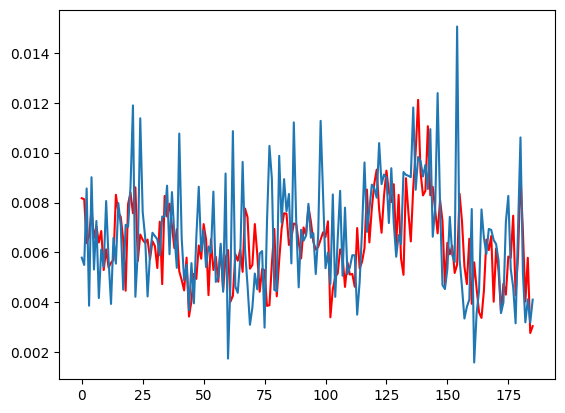

In [22]:
plt.plot(forecast[:,0], color = 'r')
plt.plot(data['Realized Volatility'].iloc[window_size:].values)

In [23]:
data_results = pd.DataFrame({'Date': data.index[window_size:], 'Realized Volatility': data['Realized Volatility'].iloc[window_size:], 'Predicted Volatility': forecast[:,0]})
data_results.to_csv('Outputs/Models/VAR/VAR_results.csv')